<a href="https://colab.research.google.com/github/haracharan/Home_Assignment-5_CNN/blob/main/Home_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.18MB/s]


Epoch [0/100] | D Loss: 0.4771 | G Loss: 0.8639
Epoch [1/100] | D Loss: 0.3175 | G Loss: 1.2382
Epoch [2/100] | D Loss: 0.4959 | G Loss: 1.4681
Epoch [3/100] | D Loss: 0.4921 | G Loss: 2.2664
Epoch [4/100] | D Loss: 0.5747 | G Loss: 2.5348
Epoch [5/100] | D Loss: 0.4813 | G Loss: 1.4106
Epoch [6/100] | D Loss: 0.4368 | G Loss: 1.6225
Epoch [7/100] | D Loss: 0.5261 | G Loss: 1.8181
Epoch [8/100] | D Loss: 0.6659 | G Loss: 1.9939
Epoch [9/100] | D Loss: 0.5108 | G Loss: 1.1897
Epoch [10/100] | D Loss: 0.5486 | G Loss: 1.0618
Epoch [11/100] | D Loss: 0.5671 | G Loss: 0.9925
Epoch [12/100] | D Loss: 0.5425 | G Loss: 1.0830
Epoch [13/100] | D Loss: 0.6408 | G Loss: 1.1888
Epoch [14/100] | D Loss: 0.6306 | G Loss: 1.1962
Epoch [15/100] | D Loss: 0.5410 | G Loss: 0.8908
Epoch [16/100] | D Loss: 0.5660 | G Loss: 0.9726
Epoch [17/100] | D Loss: 0.5523 | G Loss: 0.9681
Epoch [18/100] | D Loss: 0.5932 | G Loss: 0.6087
Epoch [19/100] | D Loss: 0.5840 | G Loss: 0.6569
Epoch [20/100] | D Loss: 0.633

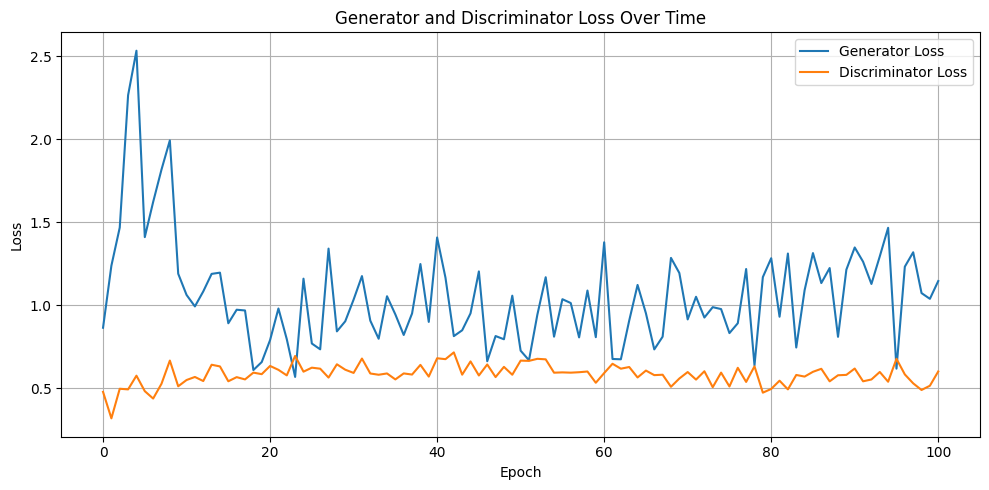

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
lr = 0.0002
batch_size = 64
epochs = 100

# Make directory to save outputs
os.makedirs("gan_outputs", exist_ok=True)

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataloader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.gen(z)
        return out.view(z.size(0), 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.dis = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.dis(x.view(x.size(0), -1))

# Instantiate models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Lists to save losses
losses_G = []
losses_D = []

# Training loop
for epoch in range(epochs + 1):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch = real_imgs.size(0)

        # Labels
        valid = torch.ones(batch, 1, device=device)
        fake = torch.zeros(batch, 1, device=device)

        # === Train Generator ===
        optimizer_G.zero_grad()
        z = torch.randn(batch, latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # === Train Discriminator ===
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Save losses
    losses_G.append(g_loss.item())
    losses_D.append(d_loss.item())

    # Save sample images
    if epoch in [0, 50, 100]:
        with torch.no_grad():
            sample = generator(torch.randn(64, latent_dim, device=device))
            save_image(sample, f"gan_outputs/sample_epoch_{epoch}.png", normalize=True, nrow=8)

    print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label="Generator Loss")
plt.plot(losses_D, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gan_outputs/loss_plot.png")
plt.show()
